#Explore Data

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns


##Input Data


In [2]:
superstore_df = pd.read_excel('/ecommerce retail.xlsx', sheet_name = "ecommerce retail")
superstore_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


##Checking missing value


In [3]:
superstore_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [4]:
superstore_df[['Quantity', 'UnitPrice', 'CustomerID']].describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000



*   Description có giá trị Null
*   Customer ID có null

*   Customer ID sai type

*   Unit Price < 0
*   Quantity < 0



##Clean Data



*   **Xóa các order bị cancel**

*   **Xóa các Customer ID bị null**
* **Đổi type cho cột Customer id**


In [5]:
superstore_df = superstore_df[superstore_df['Quantity']>0]
superstore_df.shape

(531285, 8)

In [6]:
superstore_df = superstore_df[superstore_df['UnitPrice']>0]
superstore_df.shape

(530104, 8)

In [7]:
superstore_df.dropna(subset=['CustomerID'],how='all',inplace=True)
superstore_df.shape

<ipython-input-7-a60322788c0e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  superstore_df.dropna(subset=['CustomerID'],how='all',inplace=True)


(397884, 8)

In [8]:
superstore_df['CustomerID'] = superstore_df['CustomerID'].astype(int).astype(object)
superstore_df = superstore_df.drop_duplicates()
superstore_df.info()

<ipython-input-8-5c8647d5de4f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  superstore_df['CustomerID'] = superstore_df['CustomerID'].astype(int).astype(object)


<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  object        
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 27.0+ MB


#RFM Analysis

##Tính Recency, Frequency, Monetary

In [9]:
now = dt.datetime(2011,12,31)
superstore_df['InvoiceDate'] = pd.to_datetime(superstore_df['InvoiceDate'])

superstore_df['spent'] = superstore_df['Quantity'] * superstore_df['UnitPrice']

superstore_df = superstore_df.groupby('CustomerID').agg(
                Frequency=('InvoiceNo', 'nunique'),
                Monetary=('spent', 'sum'),
                last_order_date=('InvoiceDate', 'max')).reset_index()

superstore_df['Recency'] = superstore_df['last_order_date'].apply(lambda x: (now - x).days)

superstore_df = superstore_df.drop(columns=['last_order_date'])

superstore_df

,CustomerID,Frequency,Monetary,Recency
0,12346,1,77183.60,346
1,12347,7,4310.00,23
2,12348,4,1797.24,96
3,12349,1,1757.55,39
4,12350,1,334.40,331
...,...,...,...,...
4333,18280,1,180.60,298
4334,18281,1,80.82,201
4335,18282,2,178.05,28
4336,18283,16,2045.53,24


##Tính RFM score

In [10]:
score = ['1','2','3','4','5']

superstore_df['R'] = pd.qcut(superstore_df['Recency'], q=5, labels= ['5','4','3','2','1'])

superstore_df['F'], bins_F = pd.qcut(superstore_df['Frequency'].rank(method='first'), q=5, labels = score,retbins=True)

superstore_df['M'] = pd.qcut(superstore_df['Monetary'], q=5, labels=score)

superstore_df['RFM_score'] = superstore_df['R'].astype(str) \
                            + superstore_df['F'].astype(str) \
                            + superstore_df['M'].astype(str)

superstore_df

,CustomerID,Frequency,Monetary,Recency,R,F,M,RFM_score
0,12346,1,77183.60,346,1,1,5,115
1,12347,7,4310.00,23,5,5,5,555
2,12348,4,1797.24,96,2,4,4,244
3,12349,1,1757.55,39,4,1,4,414
4,12350,1,334.40,331,1,1,2,112
...,...,...,...,...,...,...,...,...
4333,18280,1,180.60,298,1,2,1,121
4334,18281,1,80.82,201,1,2,1,121
4335,18282,2,178.05,28,5,3,1,531
4336,18283,16,2045.53,24,5,5,4,554


##Chia Segments

In [11]:
seg = pd.read_excel('/ecommerce retail.xlsx', sheet_name = "Segmentation")
seg['RFM_score'] = seg['RFM Score'].str.split(',')
seg = seg.explode('RFM_score').reset_index(drop = True)
seg.drop(columns=['RFM Score'], inplace=True)
seg

,Segment,RFM_score
0,Champions,555
1,Champions,554
2,Champions,544
3,Champions,545
4,Champions,454
...,...,...
120,Lost customers,112
121,Lost customers,121
122,Lost customers,131
123,Lost customers,141


In [12]:
superstore_df['RFM_score'] = superstore_df['RFM_score'].str.strip()
seg['RFM_score'] = seg['RFM_score'].str.strip()
superstore_df['Customer_Segment']= pd.merge(superstore_df, seg, on='RFM_score', how='left')['Segment']
superstore_df

,CustomerID,Frequency,Monetary,Recency,R,F,M,RFM_score,Customer_Segment
0,12346,1,77183.60,346,1,1,5,115,Cannot Lose Them
1,12347,7,4310.00,23,5,5,5,555,Champions
2,12348,4,1797.24,96,2,4,4,244,At Risk
3,12349,1,1757.55,39,4,1,4,414,Promising
4,12350,1,334.40,331,1,1,2,112,Lost customers
...,...,...,...,...,...,...,...,...,...
4333,18280,1,180.60,298,1,2,1,121,Lost customers
4334,18281,1,80.82,201,1,2,1,121,Lost customers
4335,18282,2,178.05,28,5,3,1,531,Potential Loyalist
4336,18283,16,2045.53,24,5,5,4,554,Champions


#Visualization & Insights

##Histogram

<ipython-input-13-c16fb2d08861>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(superstore_df[col])


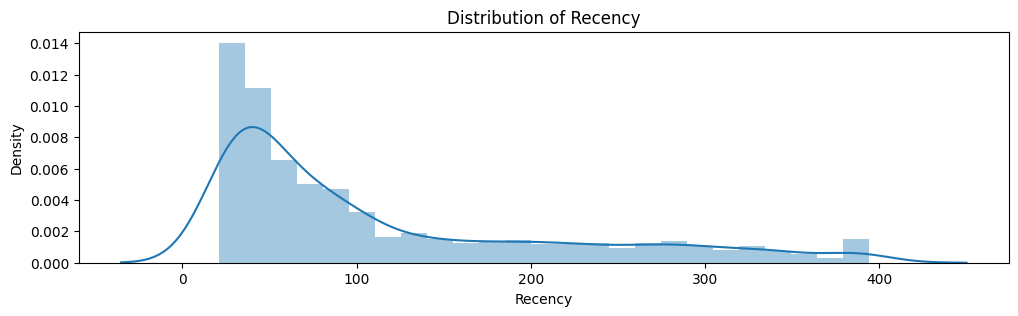

<ipython-input-13-c16fb2d08861>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(superstore_df[col])


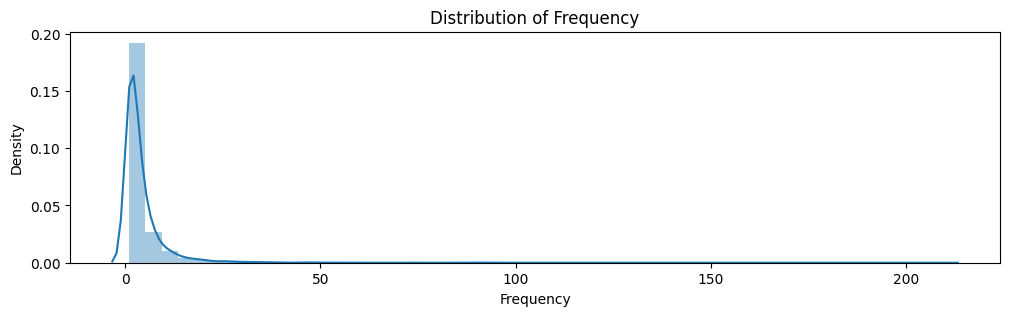

<ipython-input-13-c16fb2d08861>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(superstore_df[col])


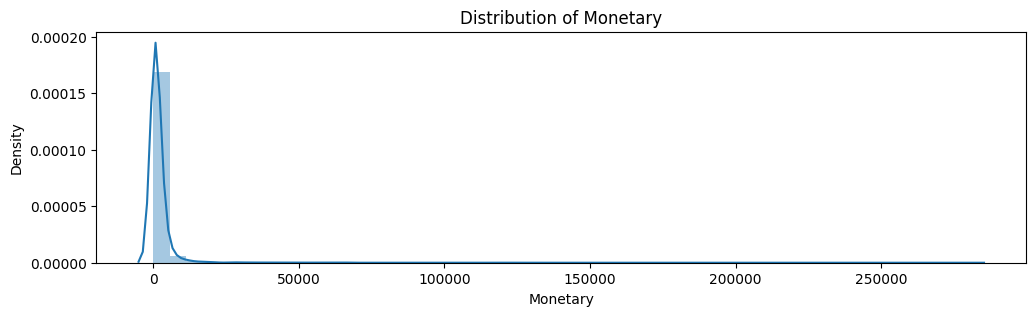

In [13]:
colname = ['Recency', 'Frequency', 'Monetary']

for col in colname:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(superstore_df[col])
    ax.set_title('Distribution of ' + col)
    plt.show()

## Chart

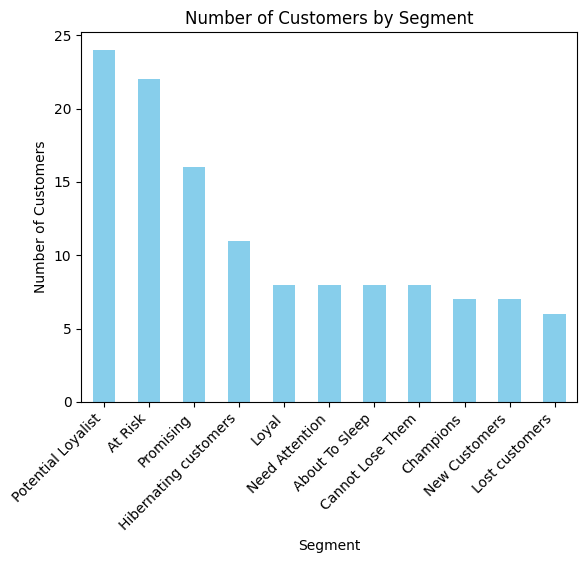

In [36]:
import matplotlib.pyplot as plt

# Count the number of customers in each segment
segment_counts = seg['Segment'].value_counts()

# Create a bar chart
segment_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Customers by Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45, ha='right')
plt.show()


<ipython-input-40-01024f92c86a>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Customer_Segment', y='Recency', data=superstore_df, palette='Set2', ci=None)
<ipython-input-40-01024f92c86a>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Customer_Segment', y='Recency', data=superstore_df, palette='Set2', ci=None)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Cannot Lose Them'),
  Text(1, 0, 'Champions'),
  Text(2, 0, 'At Risk'),
  Text(3, 0, 'Promising'),
  Text(4, 0, 'Lost customers'),
  Text(5, 0, 'Loyal'),
  Text(6, 0, 'Hibernating customers'),
  Text(7, 0, 'New Customers'),
  Text(8, 0, 'Need Attention'),
  Text(9, 0, 'Potential Loyalist'),
  Text(10, 0, 'About To Sleep')])

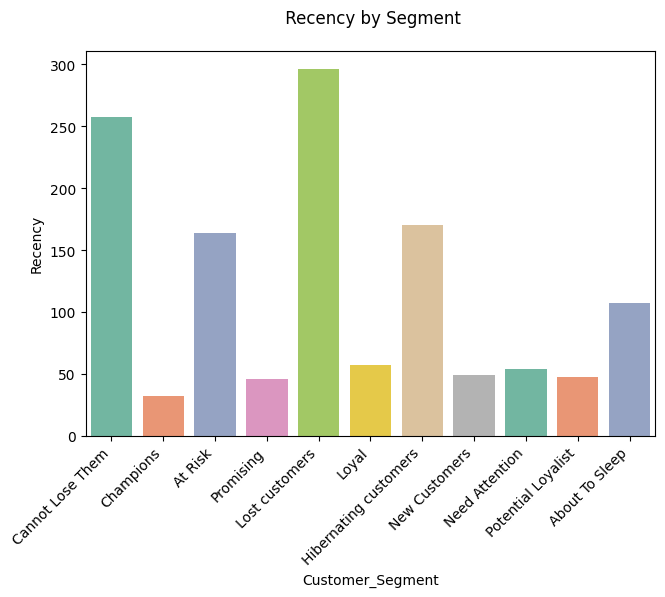

In [40]:
plt.figure(figsize=(25, 5))
plt.subplot(1, 3, 1)
sns.barplot(x='Customer_Segment', y='Recency', data=superstore_df, palette='Set2', ci=None)
plt.title(' Recency by Segment', pad=20)
plt.xticks(rotation=45, ha='right')

<ipython-input-38-82332b266ca6>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Customer_Segment', y='Frequency', data=superstore_df, palette='Set3', ci=None)
<ipython-input-38-82332b266ca6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Customer_Segment', y='Frequency', data=superstore_df, palette='Set3', ci=None)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Cannot Lose Them'),
  Text(1, 0, 'Champions'),
  Text(2, 0, 'At Risk'),
  Text(3, 0, 'Promising'),
  Text(4, 0, 'Lost customers'),
  Text(5, 0, 'Loyal'),
  Text(6, 0, 'Hibernating customers'),
  Text(7, 0, 'New Customers'),
  Text(8, 0, 'Need Attention'),
  Text(9, 0, 'Potential Loyalist'),
  Text(10, 0, 'About To Sleep')])

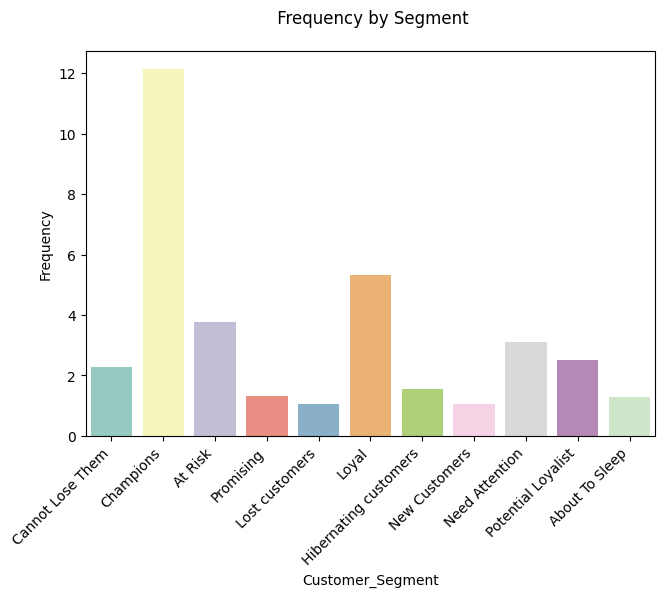

In [38]:
plt.figure(figsize=(25,5))
plt.subplot(1, 3, 2)
sns.barplot(x='Customer_Segment', y='Frequency', data=superstore_df, palette='Set3', ci=None)
plt.title(' Frequency by Segment', loc='center', pad=20)
plt.xticks(rotation=45, ha='right')

<ipython-input-39-b3a72fac2800>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Customer_Segment', y='Monetary', data=superstore_df, palette='Set1', ci=None)
<ipython-input-39-b3a72fac2800>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Customer_Segment', y='Monetary', data=superstore_df, palette='Set1', ci=None)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'Cannot Lose Them'),
  Text(1, 0, 'Champions'),
  Text(2, 0, 'At Risk'),
  Text(3, 0, 'Promising'),
  Text(4, 0, 'Lost customers'),
  Text(5, 0, 'Loyal'),
  Text(6, 0, 'Hibernating customers'),
  Text(7, 0, 'New Customers'),
  Text(8, 0, 'Need Attention'),
  Text(9, 0, 'Potential Loyalist'),
  Text(10, 0, 'About To Sleep')])

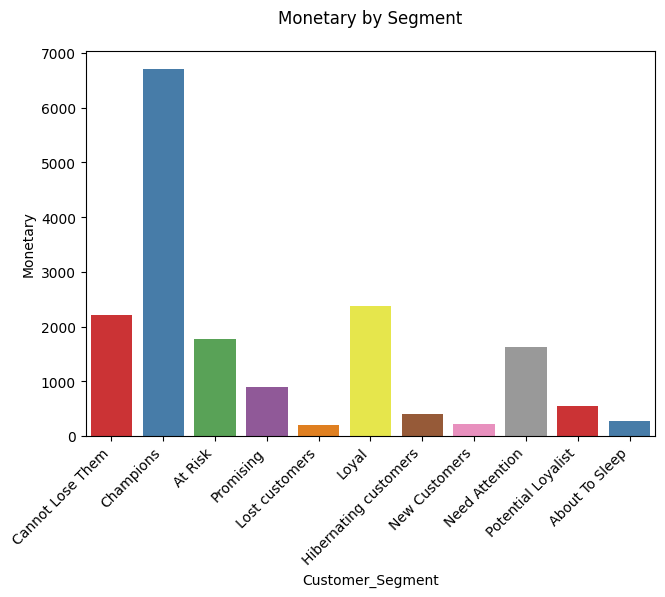

In [39]:
plt.figure(figsize=(25,5))
plt.subplot(1, 3, 3)
sns.barplot(x='Customer_Segment', y='Monetary', data=superstore_df, palette='Set1', ci=None)
plt.title('Monetary by Segment', loc='center', pad=20)
plt.xticks(rotation=45, ha='right')

##Tree map

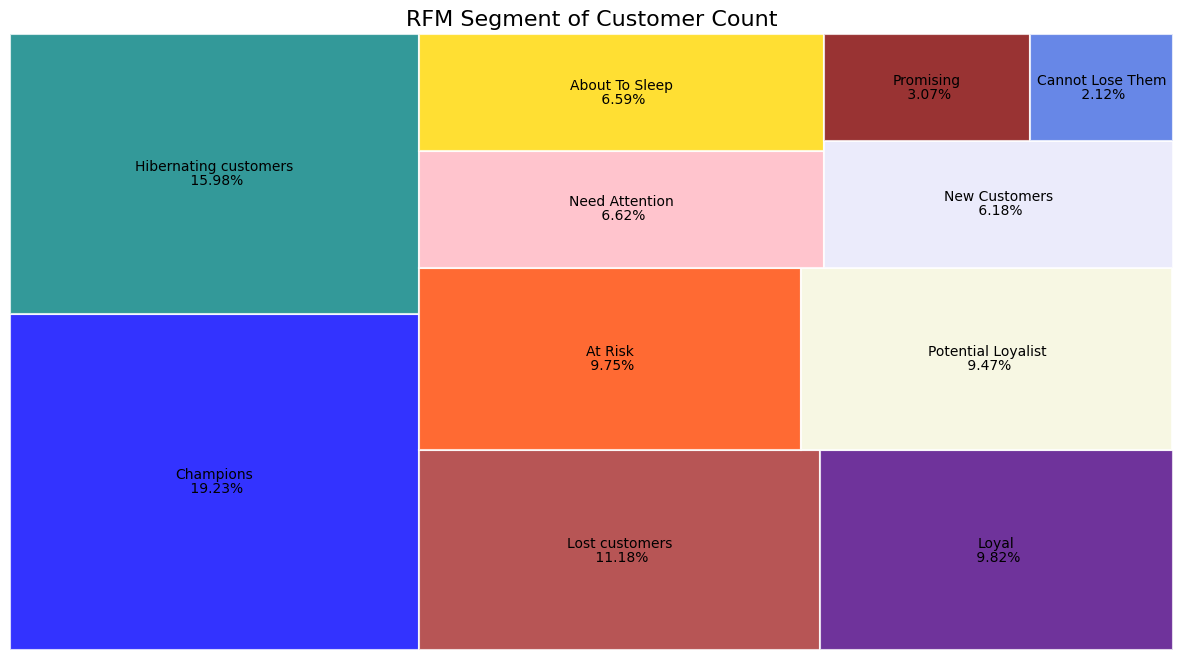

In [15]:
!pip install squarify
import squarify

colors = ['#0000FF', '#008080', '#A52A2A', '#4B0082', '#FF4500','#F5F5DC','#FFB6C1','#FFD700','#E6E6FA','#800000','#4169E1' ]
fig,ax = plt.subplots(figsize=(15,8))

squarify.plot(sizes=superstore_df['Customer_Segment'].value_counts(),
              label=superstore_df['Customer_Segment'].value_counts().index,
              value = [f'{x *100 : .2f}%' for x in superstore_df['Customer_Segment'].value_counts() /sum(superstore_df['Customer_Segment'].value_counts())],
              alpha = .8,
              color = colors,
              bar_kwargs =  {'linewidth': 1.5, 'edgecolor': 'white'}
             )
plt.title('RFM Segment of Customer Count', fontsize = 16 )
plt.axis('off')
plt.show()

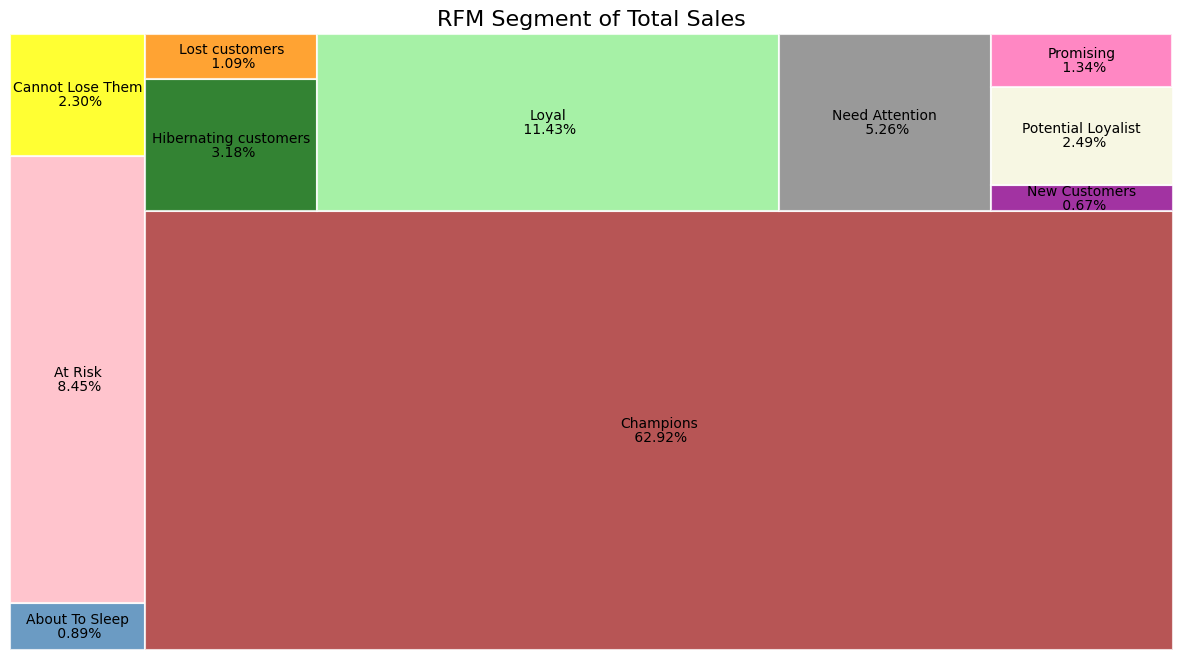

In [16]:
colorss = ['#4682B4','#FFB6C1', '#FFFF00', '#A52A2A', '#006400','#FF8C00','#90EE90','#808080','#8B008B','#F5F5DC','#FF69B4' ]
sizes = superstore_df.groupby('Customer_Segment')['Monetary'].sum().astype(int)
labels = sizes.index

fig,ax = plt.subplots(figsize=(15,8))

squarify.plot(sizes= sizes,
              label=labels,
              value = [f'{x *100 / sizes.sum(): .2f}%' for x in sizes ],
              alpha = .8,
              color = colorss,
              bar_kwargs =  {'linewidth': 1.5, 'edgecolor': 'white'}
             )
plt.title('RFM Segment of Total Sales', fontsize = 16 )
plt.axis('off')
plt.show()